In [6]:
# common
import os
import sys
import json
import pickle as pkl
import numpy as np
import warnings
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from matplotlib.ticker import FuncFormatter

def add_to_sys_path(root_dir):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        sys.path.append(dirpath)        
root_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/'
add_to_sys_path(root_dir)

# sklearn
from sklearn.metrics import mean_squared_error

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# songbirdcore
import songbirdcore.spikefinder.spike_analysis_helper as sh
import songbirdcore.spikefinder.filtering_helper as fh
import songbirdcore.utils.label_utils as luts
import songbirdcore.utils.plot_utils as puts
import songbirdcore.utils.audio_spectrogram_utils as auts

# EncoDec
from encodec import EncodecModel
from encodec.utils import convert_audio

# Tim S. noise reduce
import noisereduce as nr

# Ensongdec
import ensongdec.utils.audio_utils as au
import ensongdec.utils.signal_utils as su
import ensongdec.utils.encodec_utils as eu
from ensongdec.utils.evaluation_utils import generate_original_and_reconstructed_audio
from ensongdec.evaluation import load_model_statedict
from ensongdec.evaluation_latent_stability import load_model_statedict_align_complimentary_space

In [14]:
# Directory path
models_checkpoints_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/ensongdec/models_checkpoints/'
dataset_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/data/'
model_extension = '.pt'  # Change this to the extension you want

# Filter files based on the extension
model_files = [file for file in os.listdir(models_checkpoints_dir) if file.endswith(model_extension)]

# Print the filtered files
# print(len(filtered_files), filtered_files)

In [9]:
# Load models CSV info file
info_path = os.path.join(models_checkpoints_dir, 'models_info.csv')

# Check if the file exists and 
if os.path.isfile(info_path):
    df_models = pd.read_csv(info_path)

df_models['tot_val_err'] = df_models['tot_val_err'].apply(ast.literal_eval)
df_models['tot_train_err'] = df_models['tot_train_err'].apply(ast.literal_eval)


In [11]:
b1ra-raw  = 015856
b2ra-raw  = 031754
b1hvc-raw = 015347
b2hvc-raw = 030450

b1ra-trj  = 020155
b2ra-trj  = 031507
b1hvc-trj = 020154
b2hvc-trj = 031418

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (1477921965.py, line 1)

raw-spiketrains HVC
Loading model:  z_w12m7_20_RAW_hvc_all_FFNN_20240409_015347.pt
Loading z_w12m7_20_RAW_hvc_all_FFNN_20240409_015347_metadata.json
Loaded model: train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7]  - test_ixs:  [8, 9]  - model_layers:  [228, 64, 64, 128]
Length of neural trials: 700.0 ms, length of audio trials: 700.0 ms. 
Using 2 bins of neural data history.
CONTROL: Shuffling model inputs in the test set along the second dimension!
Dataset and Dataloader created. Samples: 808
Dataset and Dataloader created. Samples: 206
Train samples:  808 Test samples:  206
(34334,) (34334,)
raw-spiketrains RA
Loading model:  z_w12m7_20_RAW_ra_all_FFNN_20240409_015856.pt
Loading z_w12m7_20_RAW_ra_all_FFNN_20240409_015856_metadata.json
Loaded model: train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7]  - test_ixs:  [8, 9]  - model_layers:  [344, 64, 64, 128]
Length of neural trials: 700.0 ms, length of audio trials: 700.0 ms. 
Using 2 bins of neural data history.
CONTROL: Shuffling model inputs in the test set 

(Text(0, 0.5, ''), [], Text(0.5, 0, ''), [])

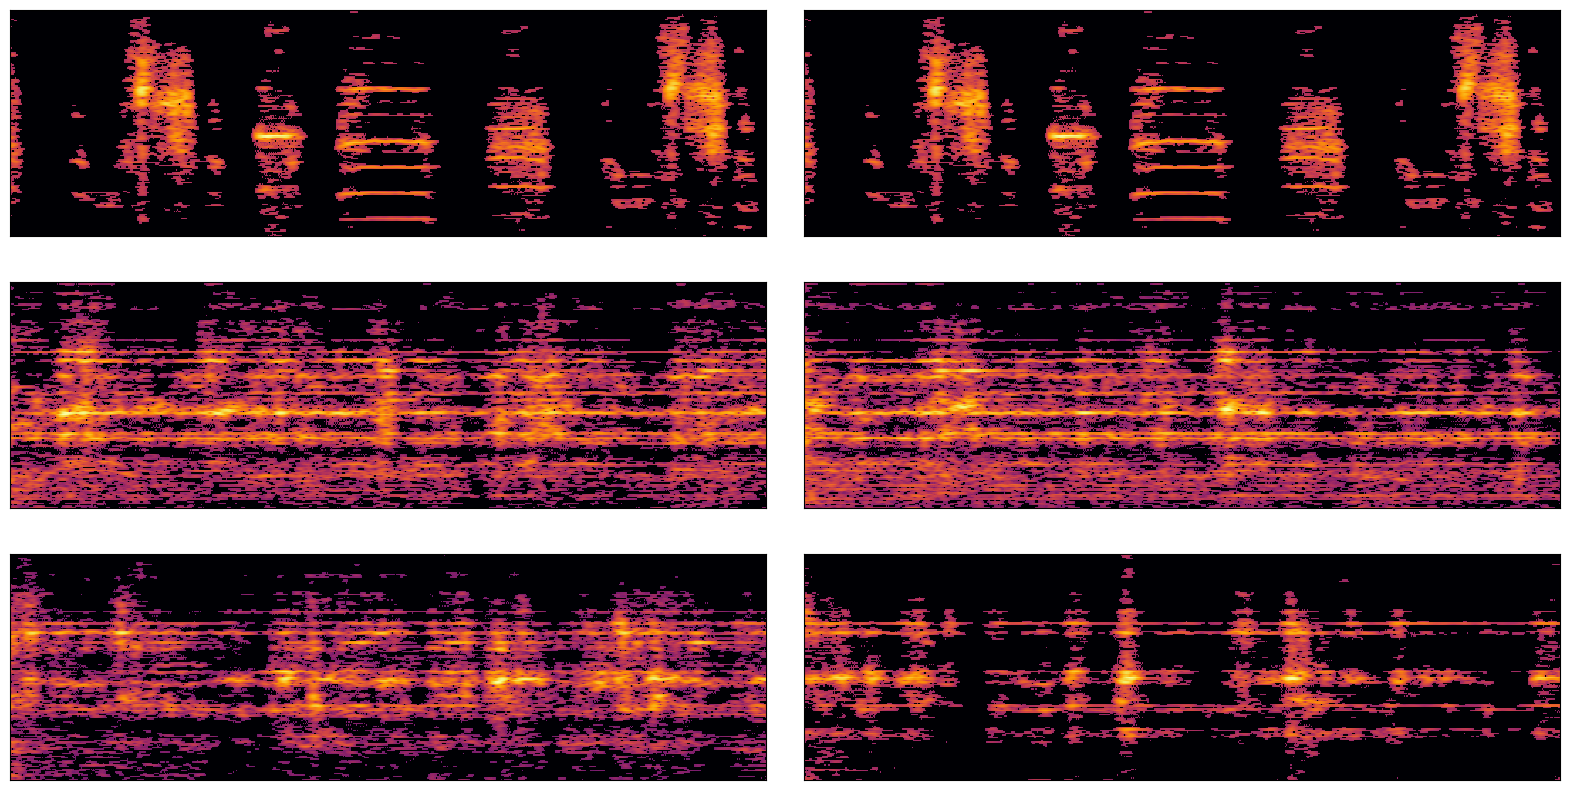

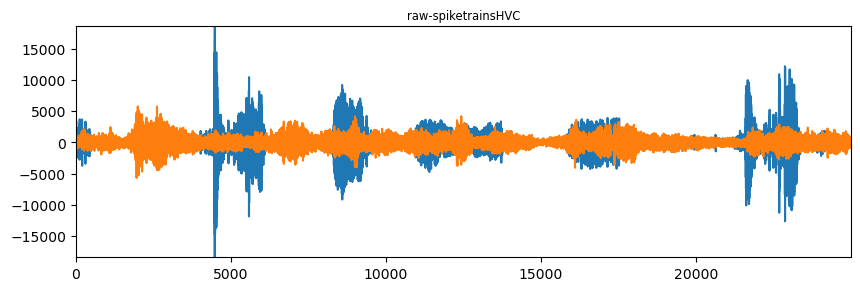

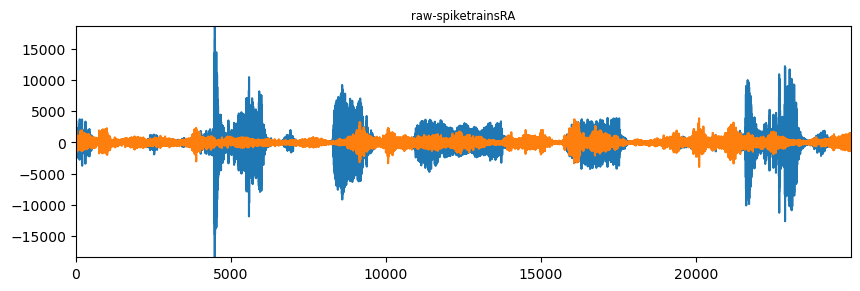

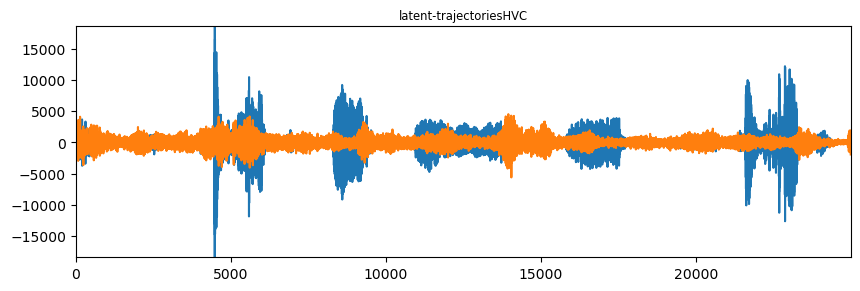

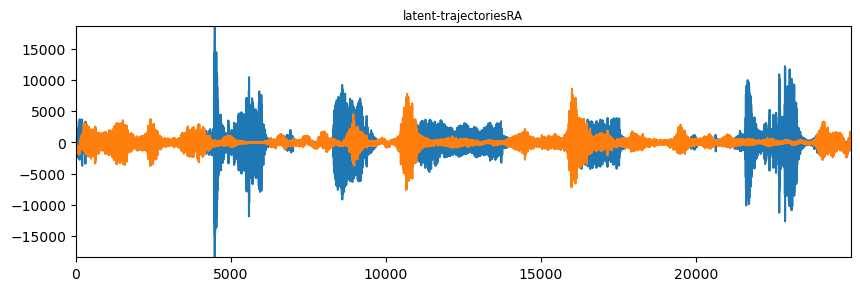

In [32]:
warnings.filterwarnings("ignore")

bird = 'z_w12m7_20'
models_dict = {
    'raw-spiketrains': {
        'HVC': '015347',
        'RA': '015856'
    },
    
    'latent-trajectories': {
        'HVC': '020154',
        'RA': '020155'
    }
}

# Dirs
models_checkpoints_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/ensongdec/models_checkpoints/'
dataset_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/data/'

column_names = ['model_name', 'nucleus', 'model', 'Spectrogram reconstruction error']
decoding_accuracy_df6 = pd.DataFrame(columns=column_names)

# Plotting setup
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
plt.subplots_adjust(wspace=0.05)

# Processing each model type and nucleus
for col, model_type in enumerate(models_dict):
    for row, nucleus in enumerate(models_dict[model_type]):

        if models_dict[model_type][nucleus]:
            print(model_type, nucleus)
    
            # Load model
            model_timestamp = models_dict[model_type][nucleus]
            model_extension = '.pt'  
            model_files = [file for file in os.listdir(models_checkpoints_dir) if file.endswith(model_extension)]
            model_filename = next((file for file in model_files if model_timestamp in file), None)
    
            print('Loading model: ', model_filename)
            ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scales = load_model_statedict(models_checkpoints_dir, dataset_dir, model_filename, shuffle_inputs=True)
    
            # Reconstruct spectrogram
            scale = torch.mean(scales)
            original_audio, decoded_audio = generate_original_and_reconstructed_audio(ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scale)
            
            print(original_audio.shape, decoded_audio.shape)
    
            # Calculate spectrogram reconstruction error
            s1 = su.normalize_signal(au.pretty_spectrogram(original_audio))
            s2 = su.normalize_signal(au.pretty_spectrogram(decoded_audio))
            spec_reconstruction_error = mean_squared_error(s1, s2, multioutput='raw_values')
            
            decoding_accuracy_df6.loc[len(decoding_accuracy_df6)] = [model_filename, nucleus, model_type, spec_reconstruction_error]
    
            # Plot original and reconstructed
            plot_s = 1
            plot_samples = int(plot_s*fs_audio)
            
            plt.subplots(nrows=1, figsize=(10, 3))
            plt.title(model_type + nucleus)
            plt.plot(original_audio[:plot_samples])
            plt.plot(decoded_audio[:plot_samples])
            
            xlabel = True if row == 1 else False
            # ylabel = True if col == 0 else False
            # au.plot_spectrogram(original_audio, fs_audio, plot_samples, ax=axes[row+1, col], xlabel=xlabel)
            au.plot_spectrogram(decoded_audio[:plot_samples], fs_audio, ax=axes[row+1, col], xlabel=xlabel)
            # Removing x and y ticks and labels
            axes[row+1, col].set_xticks([]), axes[row+1, col].set_yticks([])
            axes[row+1, col].set_xlabel(''), axes[row+1, col].set_ylabel('')

# Top row: repeat the plot of the original spectrograms in both columns
au.plot_spectrogram(original_audio[:plot_samples], fs_audio, ax=axes[0, 0], xlabel=False)
au.plot_spectrogram(original_audio[:plot_samples], fs_audio, ax=axes[0, 1], xlabel=False)
axes[0, 0].set_ylabel(''), axes[0, 0].set_yticks([]), axes[0, 0].set_xlabel(''), axes[0, 0].set_xticks([])
axes[0, 1].set_ylabel(''), axes[0, 1].set_yticks([]), axes[0, 1].set_xlabel(''), axes[0, 1].set_xticks([])

In [31]:
# Calculate statistical significance using t-test
significance = {}
for nucleus, group in decoding_accuracy_df1.groupby('model'):
    display(nucleus, group)
    hvc_error = group[group['nucleus'] == 'HVC']['Spectrogram reconstruction error'].values[0]
    ra_error = group[group['nucleus'] == 'RA']['Spectrogram reconstruction error'].values[0]
    _, p_value = stats.ttest_ind(hvc_error, ra_error)
    significance[nucleus] = p_value


# Create separate rows for each value in the 'error' list
error_type = 'Spectrogram reconstruction error'
df_expanded = decoding_accuracy_df1.explode(error_type)
df_expanded[error_type] = pd.to_numeric(df_expanded[error_type])

# Create a box and whisker plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='nucleus', y=error_type, hue='model', data=df_expanded, notch=False)

# Add significance bars
for i, p_value in enumerate(significance.values()):
    if p_value < 0.05:  # Adjust significance threshold as needed
        ax.plot([i - 0.2, i + 0.2], [0.062, 0.062], lw=1.5, c='black')  # Adjust y-coordinate and appearance as needed

# Add asterisks for statistical significance
for i, p_value in enumerate(significance.values()):
    if p_value < 0.05:  # Adjust significance threshold as needed
        plt.text(i, 0.0625, "***", ha='center', va='bottom', fontsize=16)  # Adjust position and appearance as needed



# Remove top and right spines
ax.set_ylim([0, 0.065])
ax.set_xlim([-0.5, len(significance) - 0.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=20)  # Adjust 'labelsize' as needed
plt.legend(fontsize='16', loc=(0,1.1)) 

plt.show()


'raw-spiketrains'

,model_name,nucleus,model,Spectrogram reconstruction error
0,z_w12m7_20_RAW_hvc_all_FFNN_20240409_015347.pt,HVC,raw-spiketrains,"[0.022128682775616814, 0.015305187636322408, 0..."


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
b1ra-raw  = 015856
b2ra-raw  = 031754
b1hvc-raw = 015347
b2hvc-raw = 030450

b1ra-trj  = 020155
b2ra-trj  = 031507
b1hvc-trj = 020154
b2hvc-trj = 031418

raw-spiketrains HVC
Loading model:  z_r12r13_21_RAW_hvc_all_FFNN_20240409_030450.pt
Loading z_r12r13_21_RAW_hvc_all_FFNN_20240409_030450_metadata.json
Loaded model: train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]  - test_ixs:  [37, 38, 39, 40, 41, 42, 43, 44, 45, 46]  - model_layers:  [150, 64, 64, 128]
Length of neural trials: 899.9666666666667 ms, length of audio trials: 899.96 ms. 
Using 3 bins of neural data history.
CONTROL: Shuffling model inputs in the test set along the second dimension!
Dataset and Dataloader created. Samples: 4810
Dataset and Dataloader created. Samples: 1320
Train samples:  4810 Test samples:  1320
(220000,) (220000,)
raw-spiketrains RA
Loading model:  z_r12r13_21_RAW_ra_all_FFNN_20240409_031754.pt
Loading z_r12r13_21_RAW_ra_all_FFNN_20240409_031754_metadata.json
Loaded model: train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 

(Text(0, 0.5, ''), [], Text(0.5, 0, ''), [])

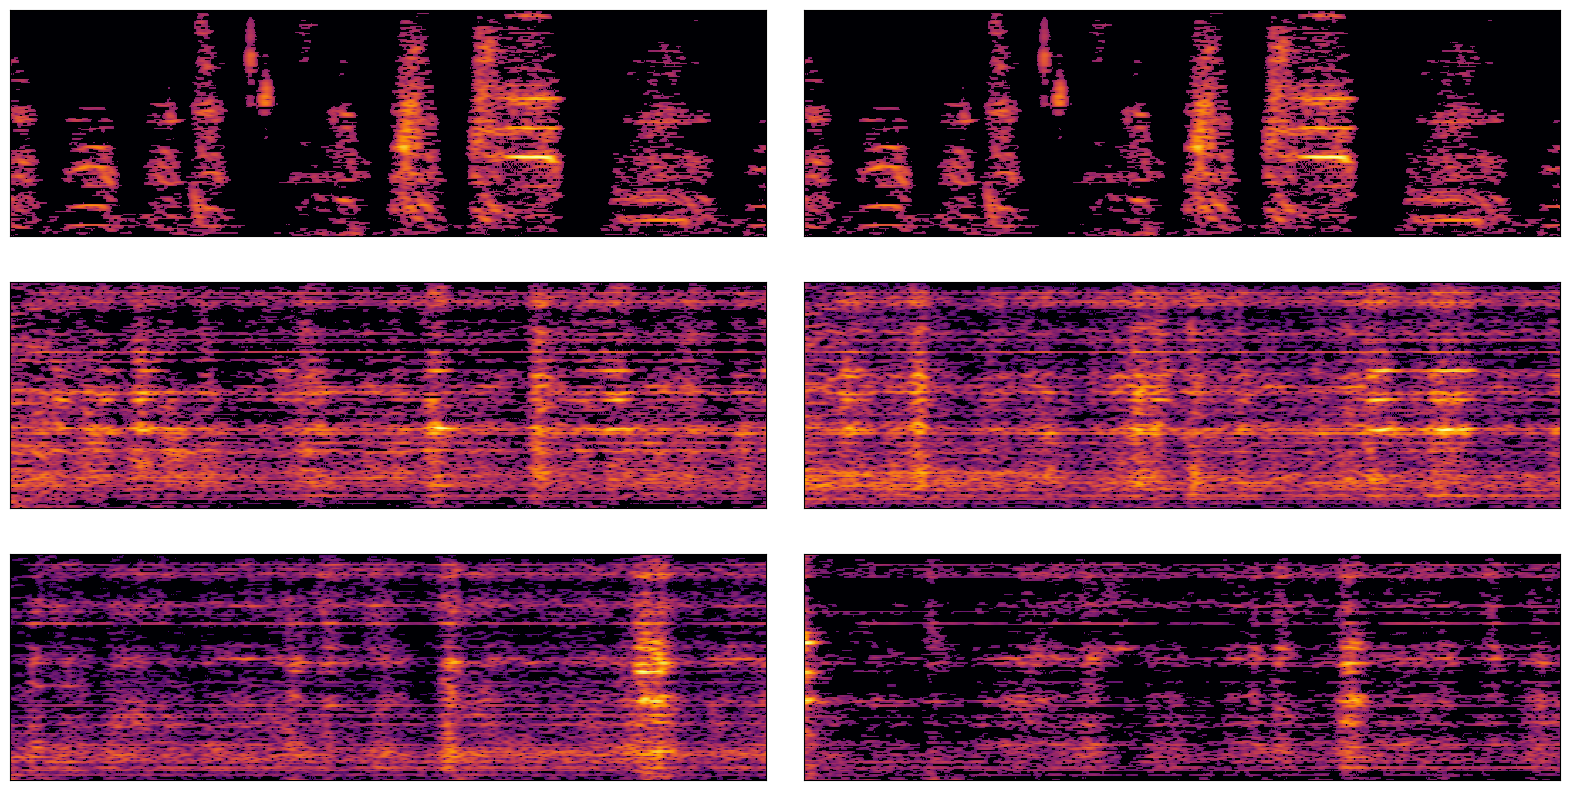

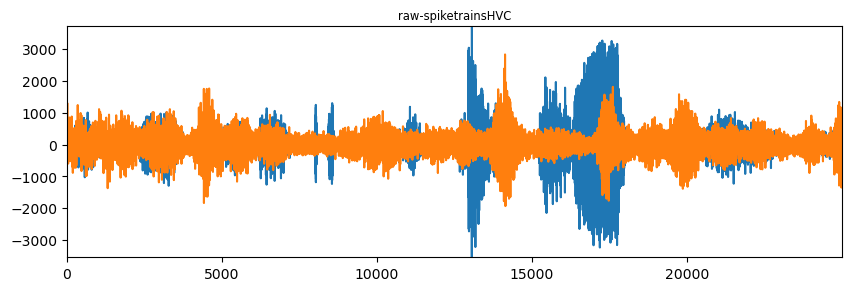

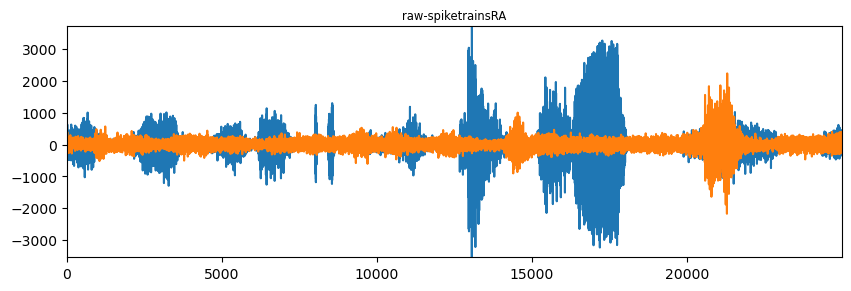

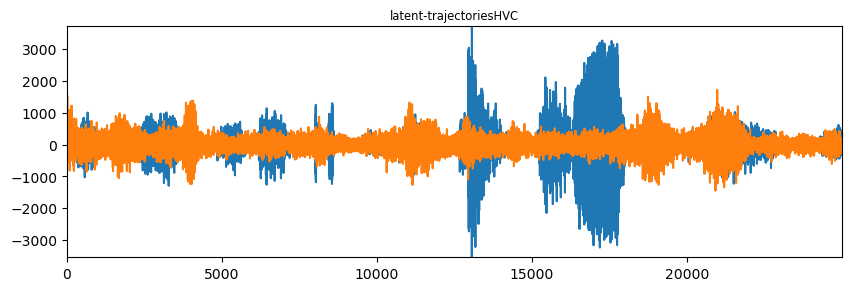

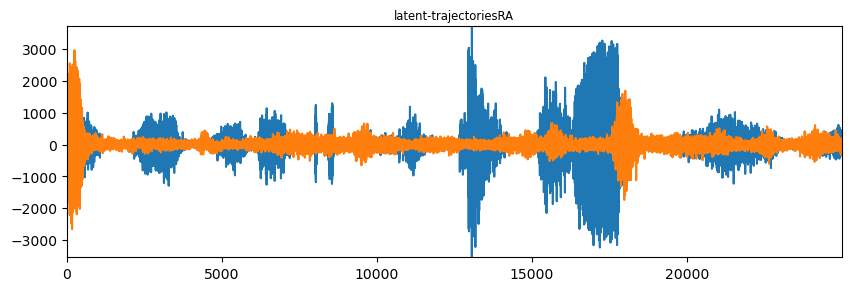

In [29]:
warnings.filterwarnings("ignore")

bird = 'z_r12r13_21'
models_dict = {
    'raw-spiketrains': {
        'HVC': '030450',
        'RA': '031754'
    },
    
    'latent-trajectories': {
        'HVC': '031418',
        'RA': '031507'
    }
}

# Dirs
models_checkpoints_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/ensongdec/models_checkpoints/'
dataset_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/data/'

column_names = ['model_name', 'nucleus', 'model', 'Spectrogram reconstruction error']
decoding_accuracy_df6 = pd.DataFrame(columns=column_names)

# Plotting setup
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
plt.subplots_adjust(wspace=0.05)

# Processing each model type and nucleus
for col, model_type in enumerate(models_dict):
    for row, nucleus in enumerate(models_dict[model_type]):

        if models_dict[model_type][nucleus]:
            print(model_type, nucleus)
    
            # Load model
            model_timestamp = models_dict[model_type][nucleus]
            model_extension = '.pt'  
            model_files = [file for file in os.listdir(models_checkpoints_dir) if file.endswith(model_extension)]
            model_filename = next((file for file in model_files if model_timestamp in file), None)
    
            print('Loading model: ', model_filename)
            ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scales = load_model_statedict(models_checkpoints_dir, dataset_dir, model_filename, shuffle_inputs=True)
    
            # Reconstruct spectrogram
            scale = torch.mean(scales)
            original_audio, decoded_audio = generate_original_and_reconstructed_audio(ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scale)
            
            print(original_audio.shape, decoded_audio.shape)
    
            # Calculate spectrogram reconstruction error
            s1 = su.normalize_signal(au.pretty_spectrogram(original_audio))
            s2 = su.normalize_signal(au.pretty_spectrogram(decoded_audio))
            spec_reconstruction_error = mean_squared_error(s1, s2, multioutput='raw_values')
            
            decoding_accuracy_df6.loc[len(decoding_accuracy_df6)] = [model_filename, nucleus, model_type, spec_reconstruction_error]
    
            # Plot original and reconstructed
            plot_s = 1
            plot_samples = int(plot_s*fs_audio)
            
            plt.subplots(nrows=1, figsize=(10, 3))
            plt.title(model_type + nucleus)
            plt.plot(original_audio[:plot_samples])
            plt.plot(decoded_audio[:plot_samples])
            
            xlabel = True if row == 1 else False
            # ylabel = True if col == 0 else False
            # au.plot_spectrogram(original_audio, fs_audio, plot_samples, ax=axes[row+1, col], xlabel=xlabel)
            au.plot_spectrogram(decoded_audio[:plot_samples], fs_audio, ax=axes[row+1, col], xlabel=xlabel)
            # Removing x and y ticks and labels
            axes[row+1, col].set_xticks([]), axes[row+1, col].set_yticks([])
            axes[row+1, col].set_xlabel(''), axes[row+1, col].set_ylabel('')

# Top row: repeat the plot of the original spectrograms in both columns
au.plot_spectrogram(original_audio[:plot_samples], fs_audio, ax=axes[0, 0], xlabel=False)
au.plot_spectrogram(original_audio[:plot_samples], fs_audio, ax=axes[0, 1], xlabel=False)
axes[0, 0].set_ylabel(''), axes[0, 0].set_yticks([]), axes[0, 0].set_xlabel(''), axes[0, 0].set_xticks([])
axes[0, 1].set_ylabel(''), axes[0, 1].set_yticks([]), axes[0, 1].set_xlabel(''), axes[0, 1].set_xticks([])

'latent-trajectories'

,model_name,nucleus,model,Spectrogram reconstruction error
2,z_r12r13_21_TRAJECTORIES_hvc_all_FFNN_20240409...,HVC,latent-trajectories,"[0.03041043316680999, 0.01753391188344881, 0.0..."
3,z_r12r13_21_TRAJECTORIES_ra_all_FFNN_20240409_...,RA,latent-trajectories,"[0.025731580454800205, 0.012215674263250096, 0..."


'raw-spiketrains'

,model_name,nucleus,model,Spectrogram reconstruction error
0,z_r12r13_21_RAW_hvc_all_FFNN_20240409_030450.pt,HVC,raw-spiketrains,"[0.02626778507321643, 0.017778199790317365, 0...."
1,z_r12r13_21_RAW_ra_all_FFNN_20240409_031754.pt,RA,raw-spiketrains,"[0.020961278085671067, 0.009517249360416119, 0..."


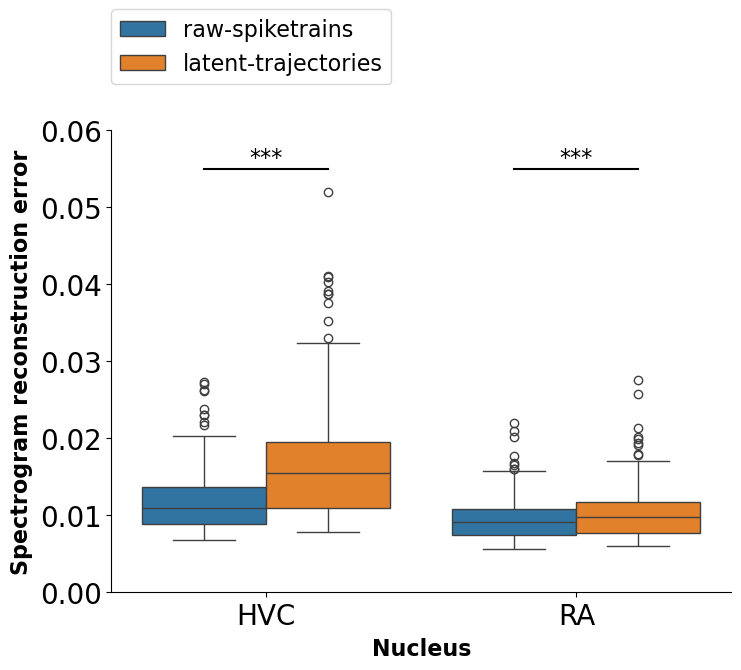

In [21]:

# Calculate statistical significance using t-test
significance = {}
for nucleus, group in decoding_accuracy_df.groupby('model'):
    display(nucleus, group)
    hvc_error = group[group['nucleus'] == 'HVC']['Spectrogram reconstruction error'].values[0]
    ra_error = group[group['nucleus'] == 'RA']['Spectrogram reconstruction error'].values[0]
    _, p_value = stats.ttest_ind(hvc_error, ra_error)
    significance[nucleus] = p_value


# Create separate rows for each value in the 'error' list
error_type = 'Spectrogram reconstruction error'
df_expanded = decoding_accuracy_df.explode(error_type)
df_expanded[error_type] = pd.to_numeric(df_expanded[error_type])

# Create a box and whisker plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='nucleus', y=error_type, hue='model', data=df_expanded, notch=False)

# Add significance bars
for i, p_value in enumerate(significance.values()):
    if p_value < 0.05:  # Adjust significance threshold as needed
        ax.plot([i - 0.2, i + 0.2], [0.055, 0.055], lw=1.5, c='black')  # Adjust y-coordinate and appearance as needed

# Add asterisks for statistical significance
for i, p_value in enumerate(significance.values()):
    if p_value < 0.05:  # Adjust significance threshold as needed
        plt.text(i, 0.055, "***", ha='center', va='bottom', fontsize=16)  # Adjust position and appearance as needed

plt.xlabel('Nucleus', fontsize=16, fontweight='bold')
plt.ylabel(error_type, fontsize=16, fontweight='bold')

# Remove top and right spines
ax.set_ylim([0, 0.06])
ax.set_xlim([-0.5, len(significance) - 0.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=20)  # Adjust 'labelsize' as needed
plt.legend(fontsize='16', loc=(0,1.1)) 

plt.show()

